#Installing and importing the libraries

In [15]:
!pip install opencv-python matplotlib imageio gdown tensorflow numpy

  Using cached tensorflow-2.18.0-cp39-cp39-macosx_12_0_arm64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached ml_dtypes-0.4.1-cp39-cp39-macosx_10_9_universal2.whl.metadata (20 kB)
Using cached tensorflow-2.18.0-cp39-cp39-macosx_12_0_arm64.whl (239.4 MB)
Using cached ml_dtypes-0.4.1-cp39-cp39-macosx_10_9_universal2.whl (396 kB)
Using cached tensorboard-2.18.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
import gdown
import imageio
import matplotlib
from matplotlib import pyplot as plt

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam,legacy
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


In [6]:
# List available physical GPU devices
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

[]

In [7]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    # Attempt to set memory growth for the first GPU
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

#DataLoading


In [7]:
# Define the URL of the dataset containing videos of 1 speaker of GRID Dataset
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'

# Define the output file name for the downloaded ZIP file
output = 'data.zip'

# Download the dataset from the specified URL
gdown.download(url, output, quiet=False)

# Extract the contents of the ZIP file
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=947a4059-7259-473a-a042-e3f100dd8dad
To: /Users/shashwatkadadriya/Development/FinalYearProject/LipNetV1/LipNetV2/LipNet/data.zip
100%|████████████████████████████████████████| 423M/423M [00:16<00:00, 24.9MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [8]:
def load_video(path: str) -> List[float]:
    """
    Load and preprocess a video from the specified path.

    Parameters:
        path (str): The path to the video file.

    Returns:
        List[float]: A list of preprocessed frames from the video."""


    # Open the video file
    cap = cv2.VideoCapture(path)

    # Initialize an empty list to store frames
    frames = []

    # Loop through all frames in the video
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        # Read a frame from the video
        ret, frame = cap.read()

        # Convert the frame to grayscale
        frame = tf.image.rgb_to_grayscale(frame)

        # Crop the frame to the region of interest i.e. lip region
        frames.append(frame[190:236, 80:220, :])

    # Release the video capture object
    cap.release()

    # Calculate mean and standard deviation for normalization
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))

    # Normalize frames and cast to float32
    return tf.cast((frames - mean), tf.float32) / std


In [9]:
#Define the vocabulary as a list of all possible characters we may encounter in our annotations
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [10]:
# String to number mapping
char_to_num = tf.keras.layers.StringLookup(
    vocabulary=vocab, oov_token=""
)

# Number to string mapping
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

# Print vocabulary information
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [11]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [12]:
def load_alignments(path:str) -> List[str]:
    """
    Load alignments from a text file at the specified path.

    Parameters:
        path (str): The path to the text file containing alignments.

    Returns:
        List[str]: A list of phonetic tokens extracted from the alignments file.
    """
    with open(path, 'r') as f:
        lines = f.readlines()

    # Initialize an empty list to store phonetic tokens
    tokens = []

    # Iterate through each line in the file
    for line in lines:
        line = line.split()
        # Check if the token is not 'sil' (silence)
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]

    # Convert phonetic tokens to numerical indices using char_to_num layer, and exclude the first space token
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]


In [13]:
def load_data(path: str):
    """
    Load data from the specified path

    Parameters:
        path (str): The path to the data file.

    Returns:
        Tuple[List[float], List[str]]: A tuple containing the loaded video frames and alignments.
    """
    # Convert path from bytes to string
    path = bytes.decode(path.numpy())

    # Extract file name from the path
    file_name = path.split('/')[-1].split('.')[0]

    # Construct paths for video and alignment files
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')

    # Load video frames
    frames = load_video(video_path)

    # Load alignments
    alignments = load_alignments(alignment_path)

    return frames, alignments


In [14]:
def mappable_function(path: str) -> List[str]:
    """
    A mappable function to load data from the specified path.

    Parameters:
        path (str): The path to the data file.

    Returns:
        List[str]: A list containing the loaded video frames and alignments.
    """
    # Call load_data using tf.py_function
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))

    return result

# Visualising One Example in our dataset


In [15]:
test_path = '/content/data/s1/bbaf2n.mpg'

In [16]:
#Load the data and unpack the frame and alignments
frames, alignments = load_data(tf.convert_to_tensor(test_path))

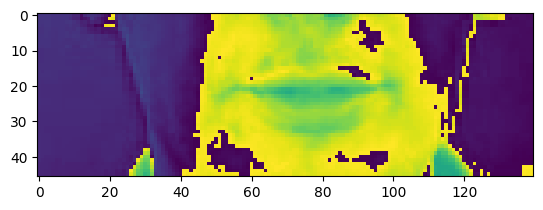

In [17]:
#Show one instance of the lip
plt.imshow(frames[40])

In [18]:
#Decode numerical alignments into human-readable phonetic tokens.
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

#Data Pipeline



In [19]:
# Load data files from the specified directory
data = tf.data.Dataset.list_files('./data/s1/*.mpg')

# Shuffle the dataset with a buffer size of 500
data = data.shuffle(500, reshuffle_each_iteration=False)

# Map the mappable_function to load data for each file in the dataset
data = data.map(mappable_function)

# Pad and batch the dataset with group size 2, padding frames to have shapes ([75,None,None,None]) and alignments to have shape ([40])
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))

# Prefetch data to improve pipeline performance
data = data.prefetch(tf.data.AUTOTUNE)

#Split Data
train = data.take(450)
test = data.skip(450)




In [ ]:
shashwat = tf.data.Dataset.list_files('./pbao8n.mpg')

In [22]:
frames, alignments = data.as_numpy_iterator().next()

2024-11-10 12:22:19.775883: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [23]:
sample = data.as_numpy_iterator()

In [24]:
val = sample.next(); val[0]

array([[[[[ 1.3969469 ],
          [ 1.3969469 ],
          [ 1.3558602 ],
          ...,
          [10.436015  ],
          [10.477102  ],
          [10.477102  ]],

         [[ 1.3969469 ],
          [ 1.3969469 ],
          [ 1.3558602 ],
          ...,
          [10.436015  ],
          [10.477102  ],
          [10.477102  ]],

         [[ 1.3558602 ],
          [ 1.3558602 ],
          [ 1.3558602 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         ...,

         [[ 0.9860802 ],
          [ 0.9860802 ],
          [ 0.9860802 ],
          ...,
          [10.271668  ],
          [10.271668  ],
          [10.271668  ]],

         [[ 0.94499356],
          [ 0.94499356],
          [ 0.94499356],
          ...,
          [10.230582  ],
          [10.230582  ],
          [10.230582  ]],

         [[ 0.94499356],
          [ 0.94499356],
          [ 0.94499356],
          ...,
          [10.230582  ],
          [10.230582  ],
          

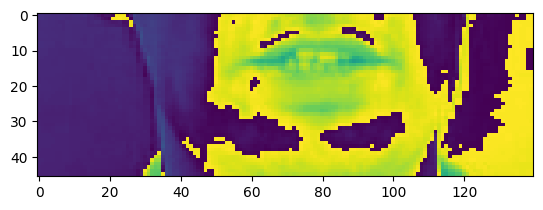

In [25]:
# 0:videos, 0: 1st video out of the batch,  35: return the 35th frame in the video
plt.imshow(val[0][0][35])

In [26]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

#MODEL


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, Activation, MaxPool3D, TimeDistributed, Flatten, Bidirectional, LSTM, Dropout, Dense

# Create a Sequential model
model = Sequential()

# Add a 3D convolutional layer with 128 filters, kernel size 3x3x3, and input shape of (75, 46, 140, 1)
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))

# Add ReLU activation function
model.add(Activation('relu'))

# Add 3D max pooling layer with pool size (1,2,2)
model.add(MaxPool3D((1,2,2)))

# Add another 3D convolutional layer with 256 filters and kernel size 3x3x3
model.add(Conv3D(256, 3, padding='same'))

# Add ReLU activation function
model.add(Activation('relu'))

# Add 3D max pooling layer with pool size (1,2,2)
model.add(MaxPool3D((1,2,2)))

# Add another 3D convolutional layer with 75 filters and kernel size 3x3x3
model.add(Conv3D(75, 3, padding='same'))

# Add ReLU activation function
model.add(Activation('relu'))

# Add 3D max pooling layer with pool size (1,2,2)
model.add(MaxPool3D((1,2,2)))

# Add TimeDistributed layer to apply Flatten operation to each time step independently
model.add(TimeDistributed(Flatten()))

# Add Bidirectional LSTM layer with 128 units, using Orthogonal kernel initializer, returning sequences
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))

# Add dropout layer with dropout rate of 0.5
model.add(Dropout(0.5))

# Add another Bidirectional LSTM layer with 128 units, using Orthogonal kernel initializer, returning sequences
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))

# Add dropout layer with dropout rate of 0.5
model.add(Dropout(0.5))

# Add Dense layer with number of units equal to vocabulary size + 1, using he_normal kernel initializer and softmax activation function
model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

#Setting up Training


In [29]:
def scheduler(epoch, lr):
    """
    Learning rate scheduler function.

    Args:
    - epoch (int): The current epoch number.
    - lr (float): The current learning rate.

    Returns:
    - float: The updated learning rate based on the epoch number.
    """

    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


In [30]:
def CTCLoss(y_true, y_pred):
    """
    Compute the Connectionist Temporal Classification (CTC) loss.

    Args:
    - y_true (tensor): True labels. Expected to have shape (batch_size, max_label_length).
    - y_pred (tensor): Predicted logits. Expected to have shape (batch_size, max_input_length, num_classes).

    Returns:
    - tensor: CTC loss.
    """

    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


In [31]:
class ProduceExample(tf.keras.callbacks.Callback):
    """
    Callback to produce examples of model predictions at the end of each epoch.

    Args:
    - dataset (tf.data.Dataset): Dataset used for evaluation.

    Methods:
    - on_epoch_end(epoch, logs=None): Called at the end of each epoch to generate and print model predictions.
    """
    def __init__(self, dataset) -> None:
        """
        Initialize the callback.

        Args:
        - dataset (tf.data.Dataset): Dataset used for evaluation.
        """
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        """
        Generate and print model predictions at the end of each epoch.

        Args:
        - epoch (int): Current epoch number.
        - logs (dict): Dictionary containing the loss value and any other metrics during training.
        """
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)


In [32]:
model.compile(optimizer =Adam(), loss=CTCLoss)

In [33]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True)

In [34]:
schedule_callback = LearningRateScheduler(scheduler)
test

<SkipDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [35]:
example_callback = ProduceExample(test)
model.input_shape



(None, 75, 46, 140, 1)

In [ ]:
processed_dataset

In [37]:
# Assuming 'test' is your dataset
def preprocess_input(tensor, target_shape=(75, 46, 140, 1)):
    # Reshape or pad to match target shape if necessary
    # This assumes tensor has shape (75, None, None, None)
    tensor = tf.reshape(tensor, [-1, *target_shape])
    return tensor

def process_dataset(dataset):
    # Map the preprocessing function to adjust the first tensor to match input shape
    dataset = dataset.map(lambda x, y: (preprocess_input(x), y))
    return dataset

# Apply the processing function to your dataset
processed_dataset = process_dataset(test)


In [38]:
print(tf.keras.__version__)

2.9.0


In [82]:
model.fit(train, validation_data=test, epochs=10, callbacks=[checkpoint_callback, schedule_callback, example_callback])


Epoch 1/10
  2/450 [..............................] - ETA: 1:50:38 - loss: 3.6396

KeyboardInterrupt: 

#PREDICTIONS

In [54]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=4d03629b-1afd-4e55-bbd9-03cd69529f39
To: /Users/shashwatkadadriya/Development/FinalYearProject/LipNetV1/LipNetV2/LipNet/checkpoints.zip
100%|██████████████████████████████████████| 94.5M/94.5M [00:13<00:00, 7.06MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [39]:
model.load_weights('models/checkpoint')

In [40]:
optimizer = legacy.Adam()


In [41]:
test_data = test.as_numpy_iterator()

In [42]:
sample = test_data.next()

[mpeg1video @ 0x1197dea80] ac-tex damaged at 22 17
[mpeg1video @ 0x1197dea80] Warning MVs not available


In [43]:
yhat = model.predict(sample[0])

1/1 [==============================] - 3s 3s/step


In [44]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set white in o three again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green with e eight please'>]

In [45]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [46]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set white in o three again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green with e eight please'>]

In [51]:
sample = load_data(tf.convert_to_tensor('/content/data/s1/sgiczp.mpg'))

In [52]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set green in c zero please'>]

In [53]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 950ms/step


In [54]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [55]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set green in c zero please'>]

In [69]:
sample

(<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
 array([[[[ 9.789988  ],
          [ 9.789988  ],
          [ 9.789988  ],
          ...,
          [ 9.789988  ],
          [ 9.789988  ],
          [ 9.789988  ]],
 
         [[ 9.789988  ],
          [ 9.789988  ],
          [ 9.789988  ],
          ...,
          [ 9.789988  ],
          [ 9.789988  ],
          [ 9.789988  ]],
 
         [[ 9.789988  ],
          [ 9.789988  ],
          [ 9.789988  ],
          ...,
          [ 9.789988  ],
          [ 9.789988  ],
          [ 9.789988  ]],
 
         ...,
 
         [[ 9.789988  ],
          [ 9.789988  ],
          [ 9.789988  ],
          ...,
          [ 9.789988  ],
          [ 9.789988  ],
          [ 9.789988  ]],
 
         [[ 9.789988  ],
          [ 9.789988  ],
          [ 9.789988  ],
          ...,
          [ 9.789988  ],
          [ 9.789988  ],
          [ 9.789988  ]],
 
         [[ 9.789988  ],
          [ 9.789988  ],
          [ 9.789988  ],
          

In [59]:
print(tf.keras.__version__)

2.9.0
